In [7]:
import rich as r

print = r.print

# Teste de Permutação

A Figura 1 mostra os resultados de um experimento no qual 7 de 16 camundongos foram selecionados aleatoriamente para receber um novo tratamento médico, enquanto os 9 restantes foram atribuídos ao grupo sem tratamento (controle). O tratamento tinha como objetivo prolongar a sobrevivência após uma cirurgia de teste. Em particular, a coluna “Data” mostra o tempo de sobrevivência após a cirurgia, em dias, para todos os 16 camundongos. Essa mesma figura também apresenta, para cada amostra: tamanho, média, desvio padrão.

Utilize o teste de permutação para responder à seguinte pergunta de pesquisa (use nível de significância igual a 5%): O tratamento prolongou a sobrevivência? Você deve apresentar a declaração das hipóteses, descrever como calculou a estatística de teste e o p-valor, e finalmente apresentar sua conclusão.

## Declaração das Hipóteses

- **Hipótese Nula (H0):** O tratamento não prolonga a sobrevivência dos camundongos.
- **Hipótese Alternativa (H1):** O tratamento prolonga a sobrevivência dos camundongos.

## Cálculo da Estatística de Teste e p-valor

Estatística de teste observada: 30.63492063492064

p-valor: 0.1403

Não rejeitamos a hipótese nula. O tratamento não prolonga a sobrevivência.

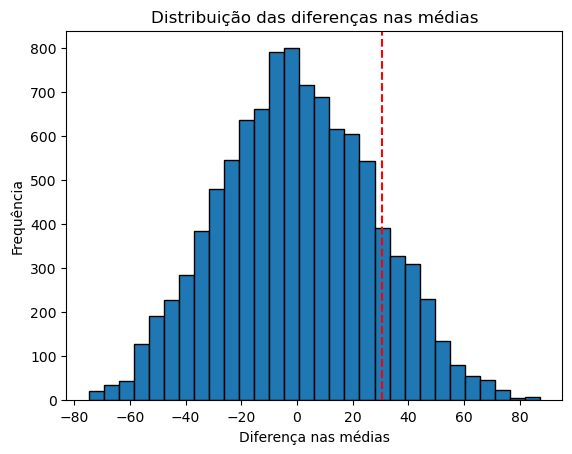

Grupo  Sobrevivencia
0   Tratamento             94
1   Tratamento            197
2   Tratamento             16
3   Tratamento             38
4   Tratamento             99
5   Tratamento            141
6   Tratamento             23
7     Controle             52
8     Controle            104
9     Controle            146
10    Controle             10
11    Controle             50
12    Controle             31
13    Controle             40
14    Controle             27
15    Controle             46

In [13]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd

tratamento = [
    94,
    197,
    16,
    38,
    99,
    141,
    23,
]
controle = [
    52,
    104,
    146,
    10,
    50,
    31,
    40,
    27,
    46,
]
data = {
    "Grupo": ["Tratamento"] * len(tratamento) + ["Controle"] * len(controle),
    "Sobrevivencia": tratamento + controle,
}

df = pd.DataFrame(data)

# Estatística de teste observada
mean_treatment = df[df["Grupo"] == "Tratamento"]["Sobrevivencia"].mean()
mean_control = df[df["Grupo"] == "Controle"]["Sobrevivencia"].mean()
observed_stat = mean_treatment - mean_control

# Função para calcular a estatística de teste para uma permutação
def perm_stat(df):
    df_permuted = df.copy()
    df_permuted["Grupo"] = np.random.permutation(df_permuted["Grupo"])
    mean_treatment_perm = df_permuted[df_permuted["Grupo"] == "Tratamento"][
        "Sobrevivencia"
    ].mean()
    mean_control_perm = df_permuted[df_permuted["Grupo"] == "Controle"][
        "Sobrevivencia"
    ].mean()
    return mean_treatment_perm - mean_control_perm


# Número de permutações
n_permutations = 10000

# Calcular estatísticas de teste para permutações
perm_stats = np.array([perm_stat(df) for _ in range(n_permutations)])

# Calcular p-valor
p_value = np.mean(perm_stats >= observed_stat)

# Resultado
print(f"Estatística de teste observada: {observed_stat}")
print(f"p-valor: {p_value}")

if p_value < 0.05:
    print("Rejeitamos a hipótese nula. O tratamento prolonga a sobrevivência.")
else:
    print("Não rejeitamos a hipótese nula. O tratamento não prolonga a sobrevivência.")

# Plotar histograma das estatísticas de teste permutadas
plt.hist(perm_stats, bins=30, edgecolor="black")
plt.axvline(observed_stat, color="red", linestyle="--")
plt.xlabel("Diferença nas médias")
plt.ylabel("Frequência")
plt.title("Distribuição das diferenças nas médias")
plt.show()

print(df)

2 Bootstrap
Essa parte do trabalho é uma adaptação do Problema 9 na seção 5.4 de An Introduction to Statistical Learning1
. O conjunto de dados usado aqui é o denominado
Boston dataset. Uma descrição desse conjunto de dados pode ser encontrada em 

(i) Com base neste conjunto de dados, forneça uma estimativa pontual para a
média populacional da variável medv. Chame essa estimativa µˆ.
(ii) Forneça uma estimativa do erro padrão de µˆ. Interprete o resultado.
(iii) Agora estime o erro padrão de µˆ usando o método Bootstrap. Como essa
estimativa se compara com sua resposta de (ii)?
(iv) Com base em sua estimativa de bootstrap de (iii), forneça um intervalo de
confiança de 95% para a média de medv. Compare-o com os resultados
obtidos usando t-test sobre o atributo medv.
(v) Com base neste conjunto de dados, forneça uma estimativa, µˆmed, para a
mediana populacional de medv.
(vi) Agora você deve estimar o erro padrão de µˆmed. Infelizmente, não há uma
fórmula simples para calcular o erro padrão da mediana. Em vez disso,
estime o erro padrão da mediana usando o método bootstrap. Comente
suas descobertas.
(vii) Forneça uma estimativa para o décimo percentil do atributo medv. Chame
essa quantidade de µˆ0.1.
(viii) Use o método bootstrap para estimar o erro padrão de µˆ0.1. Comente suas
descobertas.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# Carregar o conjunto de dados Boston
# boston = pd.read_csv("https://raw.githubusercontent.com/selva86/datasets/master/BostonHousing.csv")
df = pd.read_csv('./boston.csv', sep=',')

# Visualizar os primeiros registros do conjunto de dados
df.head()

,,,,,,,,,,,,,"CRIM ""ZN"" ""INDUS"" ""CHAS"" ""NOX"" ""RM"" ""AGE"" ""DIS"" ""RAD"" ""TAX"" ""PTRATIO"" ""B"" ""LSTAT"" ""MEDV"""
0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296.0,15.3,396.90,4.98,24.0
0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242.0,17.8,396.90,9.14,21.6
0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242.0,17.8,392.83,4.03,34.7
0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222.0,18.7,394.63,2.94,33.4
0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222.0,18.7,396.90,5.33,36.2
